## Figure - Impact of bulk plate motion on the `asc/dsc to horz/vert` decomposition

In [7]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy import view, asc_desc2horz_vert
import pyproj
plt.rcParams.update({'font.size': 12, 'font.family':'Helvetica'})

work_dir = os.path.expanduser('/net/kraken/nobak/ykliu/2022-BulkMotion')
os.chdir(work_dir)
print('Go to directory:', work_dir)

pic_dir  = os.path.join(work_dir, 'pic')

Go to directory: /net/kraken/nobak/ykliu/2022-BulkMotion


# Motion of DST

In [2]:
geod = pyproj.Geod(ellps='WGS84') # Use WGS 1984 ellipsoid.

# DST fault line [lat0, lon0, lat1, lon1] (degree) = [30.9055, 35.3844, 28.3033, 34.5927] 
gDST = geod.inv(35.3844, 30.9055, 34.5927, 28.3033)

print('\n< Dead Sea Fault >')
print('{:.1f} km     azimuth {:.1f} deg'.format(gDST[-1]/1e3, gDST[0]))

az = -1 * gDST[0]
print('Left-lateral motion azimuth from north {:.2f} (deg; anticlockwise is positive)'.format(az))


< Dead Sea Fault >
298.5 km     azimuth -164.9 deg
Left-lateral motion azimuth from north 164.91 (deg; anticlockwise is positive)


## Run decomposition

In [3]:
processor = 'topsStack'
data_dir = os.path.join(work_dir, 'data/asc_dsc_decomp/{}'.format(processor))

re_generate = False
if re_generate:
    os.chdir(data_dir)
    # masking input velocity
    !mask.py Aqaba_a087_vel.h5        -m Aqaba_a087_msk.h5 -o Aqaba_a087_vel.h5
    !mask.py Aqaba_a087_vel_bmCorr.h5 -m Aqaba_a087_msk.h5 -o Aqaba_a087_vel_bmCorr.h5
    !mask.py Aqaba_d021_vel.h5        -m Aqaba_d021_msk.h5 -o Aqaba_d021_vel.h5
    !mask.py Aqaba_d021_vel_bmCorr.h5 -m Aqaba_d021_msk.h5 -o Aqaba_d021_vel_bmCorr.h5
    
    # decomposition
    !asc_desc2horz_vert.py Aqaba_a087_vel.h5        Aqaba_d021_vel.h5        -d velocity --az $az -g Aqaba_a087_Geo.h5 Aqaba_d021_Geo.h5 --oo vel_hv.h5
    !asc_desc2horz_vert.py Aqaba_a087_vel_bmCorr.h5 Aqaba_d021_vel_bmCorr.h5 -d velocity --az $az -g Aqaba_a087_Geo.h5 Aqaba_d021_Geo.h5 --oo vel_hv_itrf.h5
    os.chdir(work_dir)

# Make a common DEM

In [4]:
dem_orig  = '/marmot-nobak/ykliu/aqaba/broad_dem_new/dem_1_arcsec/demLat_N25_N35_Lon_E032_E040.dem.wgs84'
dem_out   = os.path.join(data_dir, 'srtm_a087d021.dem')
ref_file  = os.path.join(data_dir, 'vel_hv.h5')

re_generate = False
if re_generate:
    # Read basic attributes from .h5
    atr = readfile.read(ref_file, datasetName='vertical')[1]

    # compute latitude and longitude min max
    lon_min = float(atr['X_FIRST']) - float(atr['X_STEP'])
    lon_max = float(atr['X_FIRST']) + float(atr['X_STEP']) * (int(atr['WIDTH'])+1)
    lat_max = float(atr['Y_FIRST']) - float(atr['Y_STEP'])
    lat_min = float(atr['Y_FIRST']) + float(atr['Y_STEP']) * (int(atr['LENGTH'])+1)
    print('Dimension of the dataset (length, width): {}, {}'.format(atr['LENGTH'], atr['WIDTH']))
    print('S N W E: {} {} {} {}'.format(lat_min, lat_max, lon_min, lon_max))


    # do gdalwarp on teh orignal DEM and output it
    cmd = 'gdalwarp {} {} -te {} {} {} {} -ts {} {} -of ISCE '.format(
            dem_orig, dem_out, lon_min, lat_min, lon_max, lat_max, atr['WIDTH'], atr['LENGTH'])
    os.system(cmd)

    cmd = 'fixImageXml.py -i {} -f '.format(dem_out)
    os.system(cmd)

## Plot

In [5]:
# input files
hv_file      = os.path.join(data_dir, 'vel_hv.h5')
hv_itrf_file = os.path.join(data_dir, 'vel_hv_itrf.h5')
dem_file     = os.path.expanduser(dem_out)

# input datasets and view.py options
dset_strs = [
    f'view.py {hv_file}      horizontal --figtitle Quasi-sinistral  --lalo-loc 1 0 0 1',
    f'view.py {hv_file}      vertical   --figtitle Quasi-vertical   --lalo-loc 0 0 0 1',
    f'view.py {hv_itrf_file} horizontal --figtitle Quasi-sinistral  --lalo-loc 0 0 0 1',
    f'view.py {hv_itrf_file} vertical   --figtitle Quasi-vertical   --lalo-loc 0 0 0 1',
]
cmd_base = ' -u mm/year -v -2 2 -c RdYlBu_r --lalo-label --nocbar '
cmd_base += ' --noscalebar --fontsize 12 --ref-size 2 --coastline 10m --coastline-lw 0.5 --lalo-step 2 --lalo-off -30 -14 --lalo-fs 10 '
cmd_base += f' --dem {dem_file} --dem-nocontour --shade-min -5000 --shade-max 6000 --shade-exag 0.02 '
cmd_base += ' --noverbose '
#cmd_base += ' --ref-lalo 28.73 36.66 '
cmd_base += ' --noreference '

view.py /net/kraken/nobak/ykliu/2022-BulkMotion/data/asc_dsc_decomp/topsStack/vel_hv.h5 horizontal --figtitle Quasi-sinistral --lalo-loc 1 0 0 1 -u mm/year -v -2 2 -c RdYlBu_r --lalo-label --nocbar --noscalebar --fontsize 12 --ref-size 2 --coastline 10m --coastline-lw 0.5 --lalo-step 2 --lalo-off -30 -14 --lalo-fs 10 --dem /net/kraken/nobak/ykliu/2022-BulkMotion/data/asc_dsc_decomp/topsStack/srtm_a087d021.dem --dem-nocontour --shade-min -5000 --shade-max 6000 --shade-exag 0.02 --noverbose --noreference
min/max [mm/year]: -102.4, 331.2
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/data/asc_dsc_decomp/topsStack/vel_hv.h5 vertical --figtitle Quasi-vertical --lalo-loc 0 0 0 1 -u mm/year -v -2 2 -c RdYlBu_r --lalo-label --nocbar --noscalebar --fontsize 12 --ref-size 2 --coastline 10m --coastline-lw 0.5 --lalo-step 2 --lalo-off -30 -14 --lalo-fs 10 --dem /net/kraken/nobak/ykliu/2022-BulkMotion/data/asc_dsc_decomp/topsStack/srtm_a087d021.dem --dem-nocontour --shade-min -5000 --shade-max 600

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


min/max [mm/year]: -180.8, 25.5
save figure to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Aqaba_a087_d021_topsStack_hv_comp_demed.png


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


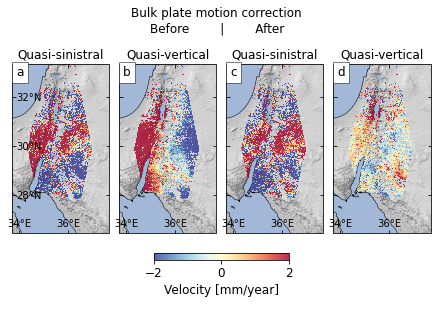

In [6]:
# plot
subplot_kw = dict(projection=ccrs.PlateCarree())
fig, axs = plt.subplots(figsize=[7.5, 4.5], nrows=1, ncols=4, subplot_kw=subplot_kw)
for ax, dset_str in zip(axs, dset_strs):
    data, atr, inps = view.prep_slice(dset_str + cmd_base)
    data -= np.nanmedian(data)
    ax, inps, im, cbar = view.plot_slice(ax, data, atr, inps)
    ax.add_feature(cfeature.OCEAN, zorder=.5, alpha=.7)
    ax.add_feature(cfeature.LAKES, zorder=.5, alpha=.7)
    print(f'min/max [mm/year]: {np.nanmin(data):.1f}, {np.nanmax(data):.1f}')
fig.subplots_adjust(wspace=0.1)

# common titles
msg =    'Bulk plate motion correction'
msg += '\nBefore        |        After'
fig.suptitle(msg, x=0.504, y=0.94, fontsize=12)
# subplot index
for ax, num in zip(axs, ['a', 'b', 'c', 'd']):
    ax.annotate(num, xy=(0.043, 0.932), xycoords='axes fraction', bbox=dict(facecolor='w', edgecolor='k', lw=0.5))

# colorbar
cax = fig.add_axes([0.387, 0.16, 0.25, 0.02])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
clabel = 'Velocity [mm/year]\n'
cbar.set_label(clabel)

# output
out_fig = os.path.join(pic_dir, 'Aqaba_a087_d021_{}_hv_comp_demed.png'.format(processor))
print('save figure to file:', out_fig)
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()